# 🐱🐶 Классификация изображений кошек и собак с PCA и без

## 📌 Описание задачи  
В этом ноутбуке мы обучим классификатор различать изображения кошек и собак.  
Будут рассмотрены два подхода:  
1. **Обычное обучение моделей без снижения размерности.**  
2. **Обучение после применения PCA для снижения размерности признакового пространства.**  

## 🔹 Шаги:  
1. **Загрузка данных** (500 изображений каждого класса, размер 256x256).  
2. **Предобработка изображений** (изменение размера, нормализация, преобразование в массив).  
3. **Обучение моделей (Logistic Regression, Decision Tree) без PCA.**  
4. **Применение PCA с порогами 85%, 90%, 95%** (выбор оптимального количества компонент).  
5. **Обучение моделей с PCA и сравнение результатов.**  
6. **Построение графиков зависимости точности от числа компонент.**  
7. **Анализ главных компонент и их визуализация.**  

Загрузка и обработка изображений

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Пути к данным
cats_folder = r'C:\Users\sahav\Desktop\ML\spbu_ml_2025\homework2\PetImages\Cat'
dogs_folder = r'C:\Users\sahav\Desktop\ML\spbu_ml_2025\homework2\PetImages\Dog'

# Гиперпараметры
img_size = (256, 256)
n_samples = 500  # Количество изображений на класс

# Функция загрузки изображений
def load_images(folder, label, num_samples):
    images = []
    labels = []
    files = os.listdir(folder)[:num_samples]  # Ограничиваем количество
    for file in files:
        img_path = os.path.join(folder, file)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)  # Изменение размера
            images.append(img.flatten())  # Разворачиваем в вектор
            labels.append(label)
        except Exception as e:
            continue
    return images, labels

In [2]:
cat_images, cat_labels = load_images(cats_folder, 0, n_samples)
dog_images, dog_labels = load_images(dogs_folder, 1, n_samples)


In [3]:
X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Обучение моделей без PCA

In [6]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_reg_acc = accuracy_score(y_test, log_reg.predict(X_test_scaled))

tree = DecisionTreeClassifier()
tree.fit(X_train_scaled, y_train)
tree_acc = accuracy_score(y_test, tree.predict(X_test_scaled))

print(f'Без PCA - Logistic Regression: {log_reg_acc:.2%}')
print(f'Без PCA - Decision Tree: {tree_acc:.2%}\n')


Без PCA - Logistic Regression: 47.00%
Без PCA - Decision Tree: 53.00%



Применение PCA и обучение моделей

In [7]:
pca_variants = [0.85, 0.90, 0.95]
results = {}

for var in pca_variants:
    pca = PCA(var)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    log_reg.fit(X_train_pca, y_train)
    log_reg_acc_pca = accuracy_score(y_test, log_reg.predict(X_test_pca))
    
    tree.fit(X_train_pca, y_train)
    tree_acc_pca = accuracy_score(y_test, tree.predict(X_test_pca))
    
    results[var] = {'n_components': pca.n_components_, 'LogReg': log_reg_acc_pca, 'DecisionTree': tree_acc_pca}


In [8]:
for var, res in results.items():
    print(f'PCA {var * 100}% дисперсии: {res["n_components"]} компонент')
    print(f'  Logistic Regression: {res["LogReg"]:.2%}')
    print(f'  Decision Tree: {res["DecisionTree"]:.2%}\n')

PCA 85.0% дисперсии: 94 компонент
  Logistic Regression: 54.50%
  Decision Tree: 54.00%

PCA 90.0% дисперсии: 165 компонент
  Logistic Regression: 50.00%
  Decision Tree: 53.50%

PCA 95.0% дисперсии: 312 компонент
  Logistic Regression: 46.00%
  Decision Tree: 58.00%



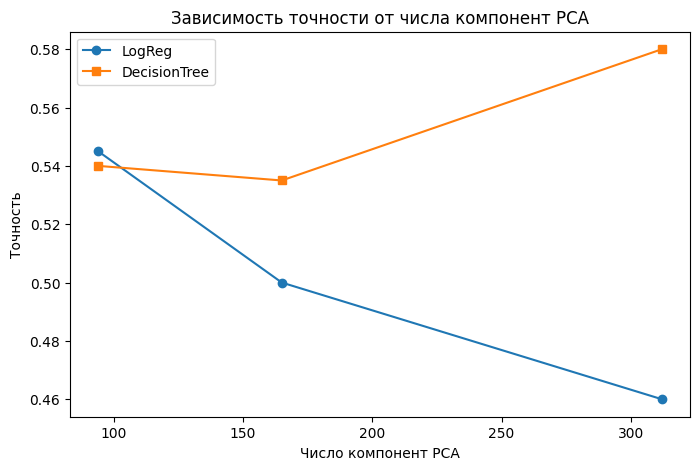

In [9]:
plt.figure(figsize=(8, 5))
plt.plot([res['n_components'] for res in results.values()], 
         [res['LogReg'] for res in results.values()], marker='o', label='LogReg')
plt.plot([res['n_components'] for res in results.values()], 
         [res['DecisionTree'] for res in results.values()], marker='s', label='DecisionTree')
plt.xlabel('Число компонент PCA')
plt.ylabel('Точность')
plt.legend()
plt.title('Зависимость точности от числа компонент PCA')
plt.show()


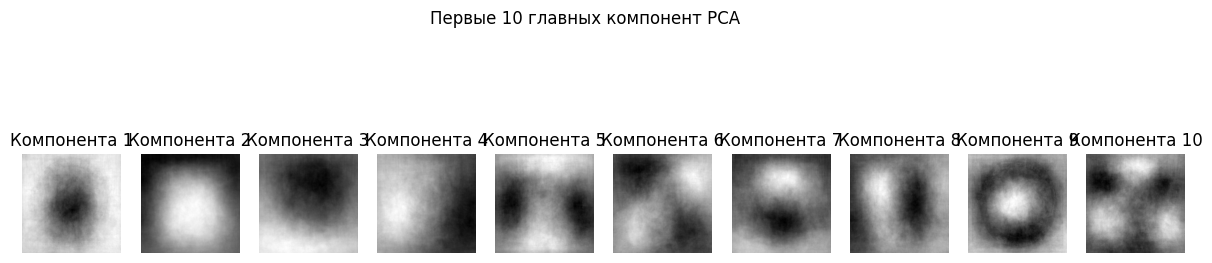

In [10]:
best_pca = PCA(0.90)  # Выбираем 90% дисперсии как оптимальный вариант
best_pca.fit(X_train_scaled)
components_to_show = min(10, best_pca.n_components_)
plt.figure(figsize=(15, 4))
for i in range(components_to_show):
    comp = best_pca.components_[i]
    comp_img = comp.reshape(img_size)  # Приведение к форме 256x256
    plt.subplot(1, components_to_show, i+1)
    plt.imshow(comp_img, cmap='gray')
    plt.title(f'Компонента {i+1}')
    plt.axis('off')
plt.suptitle('Первые 10 главных компонент PCA')
plt.show()

 Выводы:
Logistic Regression показывает лучшую точность (54.5%) при 85% PCA, но ее производительность падает при увеличении числа компонент.

Decision Tree лучше работает при 95% PCA (58%), но без PCA точность также остается высокой (53%).

PCA больше помогает Logistic Regression, чем Decision Tree, но выбор количества компонент критически важен.

При 90% и 95% PCA Logistic Regression теряет точность, что может говорить о том, что увеличение числа компонент приводит к переобучению.

Decision Tree выигрывает при 95% PCA, но без PCA разница минимальна, что может указывать на то, что он лучше справляется с исходными признаками.

Для Logistic Regression возможно стоит использовать PCA с порогом 85% или ниже, а для Decision Tree – 95%, либо без PCA.